**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers  <br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**25Apr2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Mesh](#kernels)
 + [Evaluation of Error](#Error)
 + [Setup](#setup)
 
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature at a range of $700^{o}C$ and $1000^{o}C$. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In a lithium-containing MSR, the primary tritium-producing reactions as follow

$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF $$
$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF + n' $$
$${^{19}_{9}}F + n → {^{17}_{8}}O + T $$
$${^{9}_{4}}BeF_2 + n → {^{4}_{2}}He + {^{4}_{2}}He + 2F $$


The production rate for the ternary fission reactions, seen above, in an FHR is given by Cisneros (2013). In addition to the production of tritium by ternary fission reactions, tritium is also produced by corrosion, where in an FHR the corrosion reaction (Oxidation of Cr) is given by. 

$$TF + Cr_{S.S} → CrF_2 + T_{2(g)} $$

Therefore, the purpose of this project is to understand the tritium transport phenomena and select the correct model which will be tested in MOOSE. MOOSE is a partial differential solver using Finite Element Method (FEM) developed by Idaho National Laboratory. There are already existing models available in literature that have been benchmarks such as TRITium Diffusion EvolutionN and Transport (TRIDENT) developed by Stempien et al (2015,2016) at MIT. 


## [Problem Statement](#toc)<a id="problem"></a>

Consider tritium flowing co-currently, at steady-state, in the main coolant leg with fuel-salt at an initial concentration, u ,and velocity, v. Tritium at the centerline of the bulk fluid is at its max concentration. Alternatively, no tritium is to be diffused into centerline. The latter case was considered in this model. Furthermore, sources indicate that tritium will diffuse into the pipe wall and the diffusion is limited by the mass transfer relation. The mass transfer coefficient was estimated using a Sherwood expression as such: 

$$Sh_{T_2,Pipe}=0.015Re^{0.83}Sc^{0.42}$$

The concentration of tritium in the pipe wall for an infinite slab was assumed to be 0. Lastly, no tritium was to diffuse at the exit flow. 

In [46]:
'''Domain'''

def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')

    height = 150
    radius = 7.5 
    coolant = pv.Cylinder(center=(0,0,0), direction=(1,0,0), height=height, radius=radius)

    plo = pv.Plotter(notebook=True,shape=(1,1)) 
    plo.add_mesh(coolant, color='red', opacity=1.0,)
   
    plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
    plo.set_viewup([0,1,0])
   
    cpos = plo.show(window_size=[800, 600])

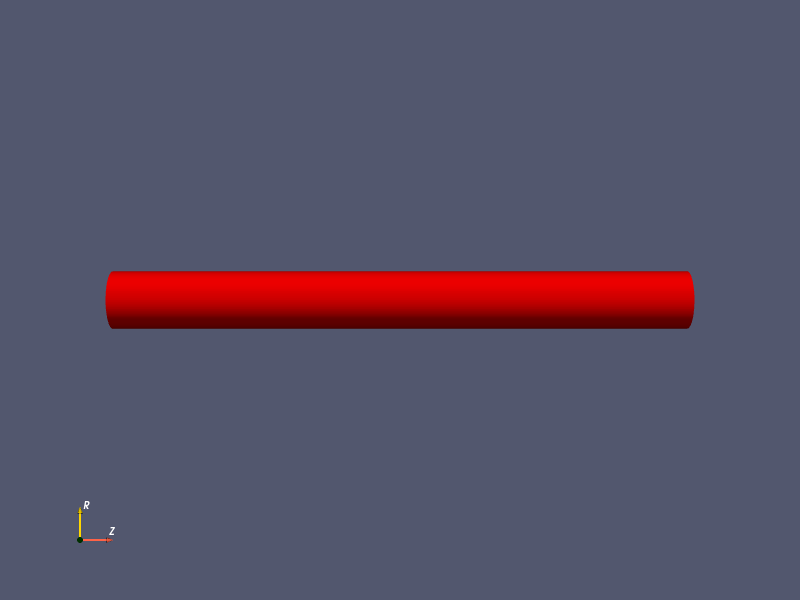

In [47]:
show_domain()

## [Objectives](#toc)<a id="obj"></a>

1.	Obtain transport parameters of tritium in main coolant leg
<br> a.	Peclet number 
<br> b.	Reynolds number
<br> c.	Diffusion coefficients
<br> d.	Fluid properties
2.	Develop Weak form of transport equation
3.	Use MOOSE to determine theoretical solution



## [Approach](#toc)<a id="app"></a>

    

### [Strong Form of Problem Statement](#toc)<a id="strongform"></a> 

<br>

Consider the transport of tritium following a 2-D Poisson’s model 
\begin{align*}
-D\nabla^2 u +\vec{v}\nabla u = 0 \\
\end{align*}

Given that the convective term will be much greater than the diffusion in the z-axis it can be neglected. Additionaly, convection in the r-axis does not exist in Steady-State conditions. 
\begin{align*}
-\frac{1} {r} \frac{d} {dr}\ ( \ Dr \frac{du} {dr} \ ) \ + \vec{v} \frac{du}{dz} \ = 0. 
\end{align*}

such that for all $ u: [(z_a, z_b); (r_a, r_b)] ∈ Real → Real $. 
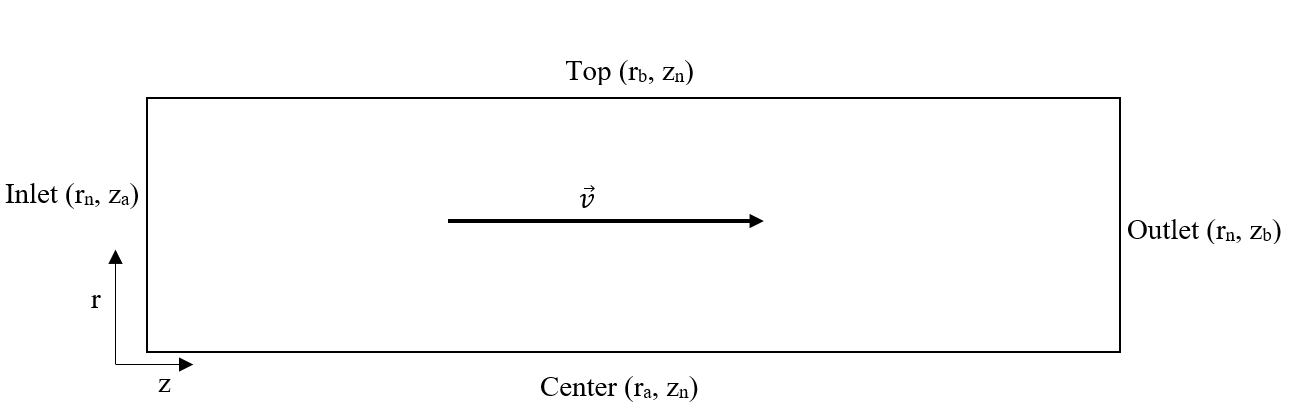

With the following Boundary Conditions \
[**Top**] : $ -q(r_b,z_n) = k(u(r)-u_\infty ) $ \
[**Center**] : $ q(r_a,z_n) = 0 $ \
[**Inlet**] : $ u(r_n,z_a) = a $ \
[**Outlet**] : $ q(r_n,z_b) = 0 $ 






### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

<br>
 Poissons Convection-Diffusion Model:
\begin{align*}
-\frac{1} {r}\frac{d} {dr}(Dr\frac{du} {dr})+\vec{v} \frac{du}{dz} =-D\nabla^2 u +\vec{v}\nabla u = 0.   \ \ (1)
\end{align*}

Multiplying by wieghted test function $\varphi\ =u(r,z)$. Followed by integration over domain $\Omega$ 
\begin{align*}
\int_\Omega (\, -\varphi D\nabla^2 u+\varphi \vec{v}\cdot\nabla u)d\Omega = 0. \ \ (2)
\end{align*}

Integration of Diffusion Term requires by parts and utilization of divergance theorem:
\begin{align*}
\int_\Omega -\varphi D\nabla^2 ud\Omega &=\int_\Omega D \nabla \varphi \cdot \nabla u\ d\Omega -\int_{\ d\Omega\ }\ \varphi D(\vec{n}\cdot\nabla u)dA         \ \ \ \             (3)
\end{align*}

Substitution of (3) into (2), results in the weak form: 
\begin{align*}
\int_\Omega D \nabla \varphi \cdot \nabla u\ d\Omega+\int_\Omega\vec{v} \cdot\nabla u\ d\Omega\ -\int_{\ d\Omega\ } \varphi D(\vec{n}\cdot\nabla u)dA =0\ \ \ (4)
\end{align*}

Where the last term in (3) is the boundary condition normal to the domain (i.e outflow and inflow)

\begin{align*} 
\ D ( \vec{n} \cdot \nabla u \ ) \ = D ( \ n_r \frac{du}{dr}+n_z\frac{du}{dz} \ ) \ \ \ \ \ (5)
\end{align*}

Substitution of (5) and the following approximate solution into the wear form (4): 
\begin{align*}
u(r,z)= \sum_{j=1}^{NN}c_j\phi_j(r,z)\ \  \ \ \ \ (6)
\end{align*}

Along with selecting the weighted function to be the $i^{th}$ shape function, i.e $\varphi =\phi_i(r,z)$, results in a computational $i{th}$ linear algebraic residual equation for NN many nodal unknowns that MOOSE will solve computationally:

\begin{align*}
R_i(r,z)= \sum_{j=1}^{NN}c_j\int_\Omega 
[\phi_i ( V_r\frac{ \partial \phi_j }{\partial r} \ + V_z\frac{ \partial \phi_j }{\partial z} )\ + D\ (\frac{ \partial \phi_i }{\partial z} \frac{ \partial \phi_j }{\partial z} + \frac{ \partial \phi_i }{\partial r} \frac{ \partial \phi_j }{ \partial r}\ ) \ d \Omega \ ]
\ - \int_{\ d \Omega} \phi_i\ [\ D ( \ n_r \frac{du}{dr} \ + \ n_z \frac{du}{dz} \ ) \ ] \ dA  \ \ \ \ \ (7)
\end{align*}


### [MOOSE Kernels](#toc)<a id="kernels"></a>

In order to input the weak form of the receding problem statment into MOOSE, it must be written in inner product notation:

\begin{align*} 
( \nabla \varphi  , D \nabla u ) - < \varphi ,D \nabla u \cdot \vec{n} > + ( \varphi , \vec {v} \cdot \nabla u )=0. 
 \end{align*}

 Where, in MOOSE\
$ ( \nabla \varphi \ , \ D \nabla u\ )  = $ Kernel
 
$ < \varphi , D\nabla u\cdot \vec{n} > = $ Boundary Condition 

$ ( \varphi , \vec {v} \cdot \nabla u ) = $ Kernel 
 

Therefore the MOOSE kernels used in this project to solve the [weak form](#weakform) are as followed:


**Diffusion Kernel** : $(\nabla \varphi,D\nabla u)$

 + [DiffusionTerm.h](./include/kernels/X.h) and [DiffusionTerm.C](./src/kernels/X.C)
 
 
**Convection Kernel** : $ ( \varphi,\vec {v} \cdot \nabla u)$

 + [ConvectionTerm.h](./include/kernels/X.h) and [ConvectionTerm.C](./src/kernels/X.C).
 
**Boundary Conditions** : $ <\varphi,D\nabla u\cdot\vec{n}> $ 

[**Top**] - [NormalFluxBC.h](./include/kernels/X.h) and [NormalFluxBC.C](./src/kernels/X.C)
 
$-q(z_n, r_b) = k(u(r)-u_\infty ) $

[**Center**]-  MOOSE implemented NeumannBC 

$ q(z_n, r_a) = 0 $
 
[**Inlet**] - MOOSE implemented DirichletBC

$ u(z_a, r_n) = a $

[**Outlet**] - MOOSE implemented NeumannBC 

$ q(z_b, r_n) = 0 $



### [Partitioning of Mesh](#toc)<a id="Mesh"></a>
Recall that Largrange polynomials are not very flexible to approximate functions over a domain. Where to over come this infelxiblity, partitioning of the domain into "smaller" slices will often reach better convergance. For this particlar domain a Nine quadrilateral elements was used as the mesh of the pipe, which is most common amongst 2D FEM problems. A Nine quadrilateral elmenet for a single element in both dimensions (r,z) follows: 

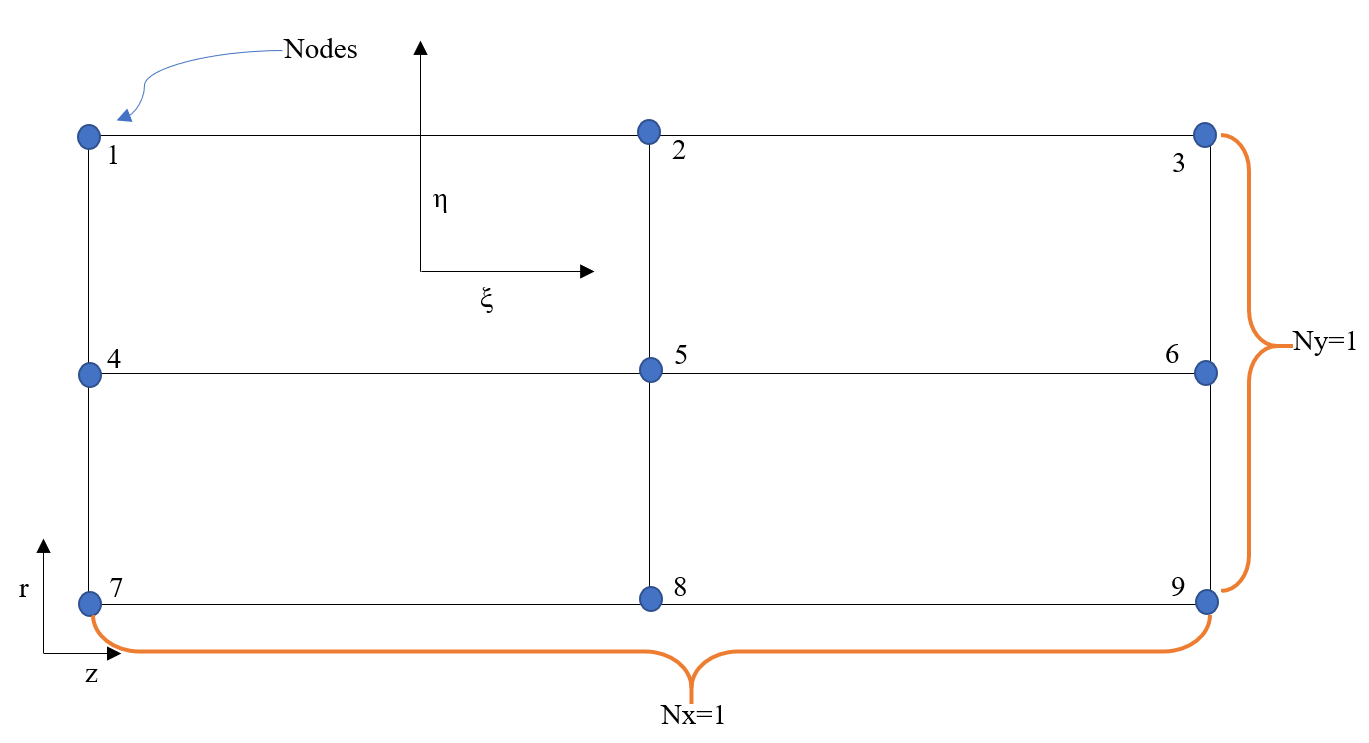

 
Where, the shape function $ \phi (\xi ,\eta )$ varies between $ N_{ij}  $ and follows the General form: 

$ \phi = A + B\xi + C\eta + D\eta\xi $

Partitioning of domain into smaller rectangles, as opposed to bilateral mesh, increases the approximated accuracy of the polynomials. 


### [Error Analysis](#toc)<a id="Error Analysis"></a>
<br>
In 2D $(r,z)$ coordinates can be written in terms of $(\xi,\eta)$ coordinates by using the previously defined 2D shape functions as follows: 

\begin{align*}
r(\xi ,\eta ) =\sum_{j=1}^{NEN}r^e_j \phi_j(\xi,\eta) \ \ \ (8)  \ \ \ \ \ z(\xi ,\eta ) =\sum_{j=1}^{NEN}z^e_j \phi_j(\xi,\eta) \  \ \ \ (9)
\end{align*} 

Where $NEN$ is the node number of an element equal to 36 for nine quadrilateral elements (9x4), and $r^e_j$ and $z^e_j$ are the known nodal coordinates of the element. For optimization of residual the dependency of $ \varphi $ , the test functions, on $(r,z)$ coordinates is determined by computing the Jacobian. Substituting (8) and (9) and differentiating results in the following Jacobian:

\begin{align*}
 J(\xi,\eta)= \ 
 \begin{bmatrix} 
\frac{\partial \phi_j}{\partial \xi }  \\ 
\frac{\partial \phi_j}{\partial \eta}  \\ 
\end{bmatrix}
=
\begin{bmatrix} 
\frac{\partial r }{\partial \xi} & \frac{\partial z }{\partial \xi}  \\ 
\frac{\partial r }{\partial \eta} & \frac{\partial r }{\partial \eta} \\ 
\end{bmatrix}
\cdot
\begin{bmatrix} 
\frac{\partial \phi_i }{\partial \xi}   \\ 
\frac{\partial \phi_i }{\partial \eta}  \\ 
\end{bmatrix}
 \end{align*}

In MOOSE this Jacobian is determined by a preconditions Jacobian matrix **PJFNK** 


### [Setup](#toc)<a id="setup"></a>

In [1]:
'''Domain'''

z_left = 0 #cm
z_right =150 #cm
r_bottom=0 #cm
r_top=7.5 #cm



'''Parameters'''
Re=5
diff_coeff = .000266493 #cm2/s
s_source = 0
fluid_density= 1940.8544 #kg/m3
fluid_viscosity=0.00158871 #Pa-s



    
vel=(Re*fluid_viscosity)/(fluid_density*(2*r_top/100))*100
print('velocity of fluid '+ '= ' + str(vel)+ ' cm/s ')

schmidt_number=(fluid_viscosity)/(fluid_density*diff_coeff)*10000
print('The Schmidt Number of the fluid =  ' + str(schmidt_number))

Sherwood_exp1=0.015*pow(Re,0.83)*pow(schmidt_number,0.42)
print('The Sherwood Number using the expression in the introduction =   ' + str(Sherwood_exp1))

Mass_transfer_coeff=(Sherwood_exp1*diff_coeff)/(2*r_top)
print('The Mass Transfer Coeffient =  ' + str(Mass_transfer_coeff)+'  cm/s')

Peclet_Number=z_right*vel/diff_coeff
print('The Peclet Number of the fluid =  ' + str(Peclet_Number))



velocity of fluid = 0.0027285405850124562 cm/s 
The Schmidt Number of the fluid =  30.71608543202774
The Sherwood Number using the expression in the introduction =   0.24039754416899317
The Mass Transfer Coeffient =  4.270950849215167e-06  cm/s
The Peclet Number of the fluid =  1535.804271601387


In [2]:
'''Data (boundary conditions)'''

u_inlet = 3.6e-07 #ug/cc
q_center=0 #ug/cm^2
q_bottom=0 #ug/cm^2
ambient_conc = 0 #ug/cm^2
velocity=[vel,0,0] #cm/s
print(vel)
Mass_transfer_coef= Mass_transfer_coeff #cm/s
print(Mass_transfer_coef)

0.0027285405850124562
4.270950849215167e-06


In [3]:
'''FEM Solution'''

n_felem_x = 1
n_felem_y = 50
mesh_type='QUAD9'
order = 'second'



from tools.toolkit  import write_engy5310_p1_2d_input_file


write_engy5310_p1_2d_input_file(xmin=z_right, 
                                xmax=z_left, 
                                yminx=r_bottom, 
                                ymax=r_top, 
                                u_inlet=u_inlet, 
                                flux_center=q_center,
                                flux_bottom=q_bottom,
                                Ambient_conc=ambient_conc,
                                velocity=vel,
                                Mass_transfer_coef=Mass_transfer_coef,
                                diff_coeff=diff_coeff, 
                                source_s=source_s, 
                                n_felem_x=n_felem_x, 
                                n_felem_y=n_felem_y, 
                                degree=order,
                                mesh_type=mesh_type,
                                compute_diffusion_flux=True,
                                use_moose_neumann_bc=True,
                                file_name='input.hit')


ModuleNotFoundError: No module named 'tools'

In [5]:
!./engy5310p1-opt -i input.hit



Framework Information:
MOOSE Version:           git commit 6fac045ef1 on 2021-02-25
LibMesh Version:         
PETSc Version:           3.14.2
SLEPc Version:           3.14.0
Current Time:            Sun May  9 15:40:23 2021
Executable Timestamp:    Sat May  8 16:47:55 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 1803
    Local:                 1803
  Elems:                   
    Total:                 300
    Local:                 300
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                1803
  Num Local DOFs:          1803
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                1800
  Num Local DOFs:          1800
  Variables:               { "diff

    150 Linear |R| = 5.597898e-12
    151 Linear |R| = 5.595266e-12
    152 Linear |R| = 5.459347e-12
    153 Linear |R| = 5.325328e-12
    154 Linear |R| = 5.252484e-12
    155 Linear |R| = 5.069080e-12
    156 Linear |R| = 4.991794e-12
    157 Linear |R| = 4.850893e-12
    158 Linear |R| = 4.729292e-12
    159 Linear |R| = 4.626502e-12
    160 Linear |R| = 4.458153e-12
    161 Linear |R| = 4.364929e-12
    162 Linear |R| = 4.229415e-12
    163 Linear |R| = 4.120089e-12
    164 Linear |R| = 4.013486e-12
    165 Linear |R| = 3.851596e-12
    166 Linear |R| = 3.777370e-12
    167 Linear |R| = 3.675138e-12
    168 Linear |R| = 3.584829e-12
    169 Linear |R| = 3.504286e-12
    170 Linear |R| = 3.390695e-12
    171 Linear |R| = 3.327857e-12
    172 Linear |R| = 3.233058e-12
    173 Linear |R| = 3.158631e-12
    174 Linear |R| = 3.075181e-12
    175 Linear |R| = 3.023013e-12
    176 Linear |R| = 2.971286e-12
    177 Linear |R| = 2.893696e-12
    178 Linear |R| = 2.860885e-12
    179 Linear

      2 Linear |R| = 5.779137e-14
      3 Linear |R| = 5.644961e-14
      4 Linear |R| = 5.469182e-14
      5 Linear |R| = 5.323078e-14
      6 Linear |R| = 5.218381e-14
      7 Linear |R| = 5.093109e-14
      8 Linear |R| = 4.860880e-14
      9 Linear |R| = 4.784060e-14
     10 Linear |R| = 4.662631e-14
     11 Linear |R| = 4.577925e-14
     12 Linear |R| = 4.399535e-14
     13 Linear |R| = 4.244571e-14
     14 Linear |R| = 4.161979e-14
     15 Linear |R| = 4.083760e-14
     16 Linear |R| = 4.029625e-14
     17 Linear |R| = 3.896826e-14
     18 Linear |R| = 3.762267e-14
     19 Linear |R| = 3.658407e-14
     20 Linear |R| = 3.542347e-14
     21 Linear |R| = 3.483614e-14
     22 Linear |R| = 3.389130e-14
     23 Linear |R| = 3.321030e-14
     24 Linear |R| = 3.249107e-14
     25 Linear |R| = 3.207808e-14
     26 Linear |R| = 3.144493e-14
     27 Linear |R| = 3.060076e-14
     28 Linear |R| = 2.891663e-14
     29 Linear |R| = 2.399370e-14
     30 Linear |R| = 2.092866e-14
     31 Linear

    190 Linear |R| = 1.815987e-16
    191 Linear |R| = 1.761194e-16
    192 Linear |R| = 1.705302e-16
    193 Linear |R| = 1.629867e-16
    194 Linear |R| = 1.577451e-16
    195 Linear |R| = 1.517735e-16
    196 Linear |R| = 1.482168e-16
    197 Linear |R| = 1.438115e-16
    198 Linear |R| = 1.393471e-16
    199 Linear |R| = 1.349096e-16
    200 Linear |R| = 1.302840e-16
    201 Linear |R| = 1.275358e-16
    202 Linear |R| = 1.240299e-16
    203 Linear |R| = 1.214135e-16
    204 Linear |R| = 1.178582e-16
    205 Linear |R| = 1.146577e-16
    206 Linear |R| = 1.124620e-16
    207 Linear |R| = 1.092556e-16
    208 Linear |R| = 1.069796e-16
    209 Linear |R| = 9.980770e-17
    210 Linear |R| = 9.537513e-17
    211 Linear |R| = 9.365070e-17
    212 Linear |R| = 8.635973e-17
    213 Linear |R| = 8.432817e-17
    214 Linear |R| = 8.252872e-17
    215 Linear |R| = 8.040644e-17
    216 Linear |R| = 7.852446e-17
    217 Linear |R| = 7.557921e-17
    218 Linear |R| = 7.394722e-17
    219 Linear

    379 Linear |R| = 1.293809e-18
    380 Linear |R| = 1.210220e-18
    381 Linear |R| = 1.144620e-18
    382 Linear |R| = 1.097782e-18
    383 Linear |R| = 1.055926e-18
    384 Linear |R| = 1.023032e-18
    385 Linear |R| = 9.892198e-19
    386 Linear |R| = 9.595891e-19
    387 Linear |R| = 9.327609e-19
    388 Linear |R| = 9.095377e-19
    389 Linear |R| = 8.884163e-19
    390 Linear |R| = 8.662467e-19
    391 Linear |R| = 8.570896e-19
    392 Linear |R| = 8.316486e-19
    393 Linear |R| = 8.145899e-19
    394 Linear |R| = 7.905343e-19
    395 Linear |R| = 7.719028e-19
    396 Linear |R| = 7.406834e-19
    397 Linear |R| = 7.195405e-19
    398 Linear |R| = 6.933678e-19
    399 Linear |R| = 6.658502e-19
    400 Linear |R| = 6.312476e-19
    401 Linear |R| = 5.912024e-19
    402 Linear |R| = 5.644687e-19
 2 Nonlinear |R| = 5.733186e-19
 Solve Converged!
The .pvtu extension should be used when writing VTK files in libMesh.

## [Results and Analysis](#toc)<a id="ranalysis"></a>

In [6]:

'''Plot function for FEM Solution'''

def plot_solution(df,
                  dimension='Null',
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import numpy as np
    plt.style.use('dark_background')
    radial ="r" 
    axial="z"
    (fig, ax1) = plt.subplots(1, figsize=(14, 5))
    
    #radial plot
    
    if (radial == dimension):
        ax1.plot(df['y'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$r$ ', fontsize=18)
        ax1.set_ylabel(r'$u_h(r)$ [µg/cc]', fontsize=18, color='red')
        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
        
        ax2 = ax1.twinx()
        ax2.plot(df['y'], df['diffFluxU_radius'],'b*-',label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(r)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        
    #Axial plot   
    
    if (axial == dimension):
        ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$z$ [cm]', fontsize=18)
        ax1.set_ylabel(r'$u_h(z)$ [µg/cc]', fontsize=18, color='red')

        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
            
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_axial'],'b*-',label=flux_basis_functions_type)
        
        ax2.set_ylabel(r"$q_h(x)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
      



    plt.title(title, fontsize=20)
  
    plt.show()
    print('')

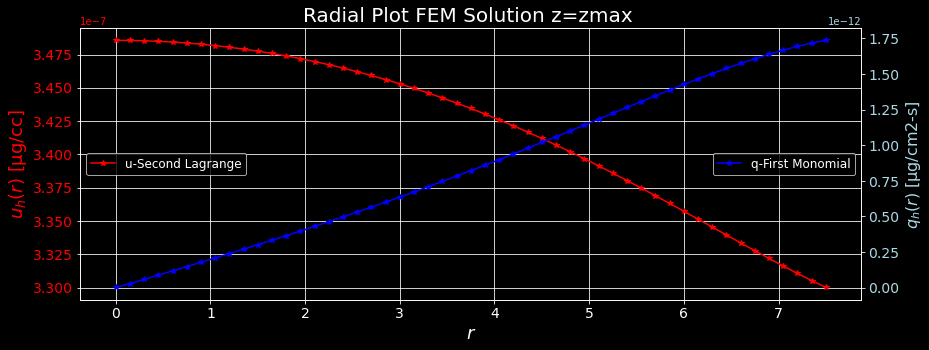

In [7]:
import pandas as pd
df = pd.read_csv('out-radial_radial-line_0002.csv')

    
plot_solution(df, dimension='r', title='Radial Plot FEM Solution z=zmax ', basis_functions_type='u-Second Lagrange', flux_basis_functions_type='q-First Monomial')

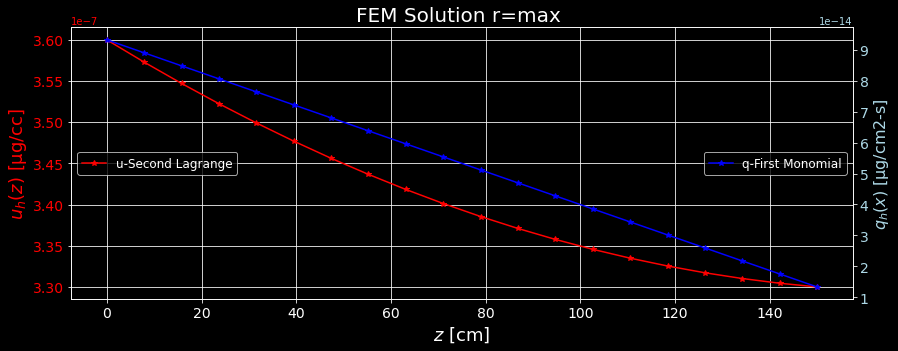

In [8]:
import pandas as pd
df = pd.read_csv('out-axial_axial-line_0002.csv')

    
plot_solution(df, dimension='z', title='FEM Solution r=max ', basis_functions_type='u-Second Lagrange',flux_basis_functions_type='q-First Monomial')

In [ ]:

'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')

plo = pv.Plotter()   

plo.add_mesh(poisson, scalars='u', cmap='plasma', stitle='Concentration [µg/cc]')


plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
plo.show_bounds()
plo.set_scale(xscale=2, yscale=5, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


In [ ]:
'''Show 2D solution'''

import pyvista as pv

poisson = pv.read('out_000_0.vtu')

plo = pv.Plotter()   
plo.add_mesh(poisson, scalars='diffFluxU_radius', cmap='plasma', stitle='Diffusion Flux R [µg/(cm^2 s)]')
plo.add_axes(xlabel='Z', ylabel='R', zlabel='')


plo.show_bounds()
plo.set_scale(xscale=None, yscale=3, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])

cpos = plo.show(window_size=[800, 600])


In [ ]:
'''Show 2D solution'''

import pyvista as pv

poisson = pv.read('out_000_0.vtu')
plo = pv.Plotter()   
plo.add_mesh(poisson, scalars='diffFluxU_axial', cmap='plasma', stitle='Diffusion Flux Z [µg/(cm^2 s)]')
plo.add_axes(xlabel='Z', ylabel='R', zlabel='')

plo.set_scale(xscale=None, yscale=3, zscale=None, reset_camera=True)
plo.show_bounds()
plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


## [Conclusions](#toc)<a id="conclusions"></a>

The results shown above, shows the transport of tritium in a pipe. It was assumed that the diffusion in the z direction is to be completely neglectable due to the Peclet Number, ratio of convection to diffusion, being in the order of $10^8$ magnitude. The impactfullness of the convection term relative to diffusion is seen on the Radial Plot. 

The concentration at the surface of pipe, starting from inlet to outlet, is directly proportial to the Newtonian fluid viscious force profile  $F=\mu A \frac{v}{y}$ . At the wall of the pipe no-slip condition assumes that the velocity is 0 and the shear stress is directly proportional to the slope of the velocity profile. For turbulent conditions the velocity profile is as such:

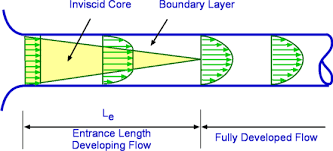


In the problem statement, steady state (S.S) condition was applied where in solving S.S conditions the inflow is still developing and the exit is solved as fully developed. Therefore  the concentration at the surface of the pipe, starting from inlet to outlet, should resemble the shear force profile. While the radial concentration follows the velocity profile. 


## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310),  University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] Stempien D. John, “Tritium Transport, Corrosion, and Fuel Performance Modeling in Fluoride Salt-Cooled High-Temperature Reactor (FHR)”. Massachusetts Institute of Technology. PDF. June 2017
- [4] R. Serrano-Lópeza, J. Fraderaa, S. Cuesta-Lópeza. “Molten salts database for energy applications”. PDF. September 2014.